['joy', 'fear', 'anger', 'sadness', 'love', 'surprise']


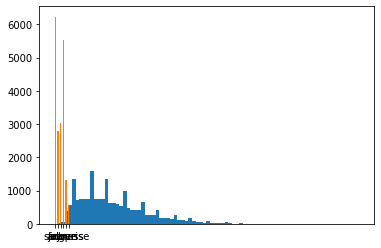

NameError: name 'maxlen' is not defined

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import random
from sklearn.metrics import classification_report
from sklearn.metrics import fbeta_score

#Create functions for the accuracy and loss graphs
def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

#Create functions for the confusion matrix    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

#Load the train, validation and testing datasets   
train = pd.read_csv("G:\My Drive\AnjanaValsalan_ECNG 3020\Implementation Files\Datasets\ECNG3020_Final_Dataset\ECNG3020_Train_Dataset.csv")
test = pd.read_csv("G:\My Drive\AnjanaValsalan_ECNG 3020\Implementation Files\Datasets\ECNG3020_Final_Dataset\ECNG3020_Test_Dataset.csv")
val = pd.read_csv("G:\My Drive\AnjanaValsalan_ECNG 3020\Implementation Files\Datasets\ECNG3020_Final_Dataset\ECNG3020_Val_Dataset.csv")

#Create function that separate text and labels in the dataset into different variables
def get_text(data):
    text = data['text']
    labels = data['label']
    labels = labels.replace(["0","1","2","3","4","5"],['sadness','joy','love','anger','fear','surprise'])
    return text, labels

#Apply get_text() function to the train set
text, labels = get_text(train)

#Use the TensorFlow Keras Tokenizer on the text values from the train set
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(text)

#Plot a histogram for the lengths of each text value in the train set to determine a value for max_length
lengths = [len(t.split(' ')) for t in text]
plt.hist(lengths, bins = len(set(lengths)))
plt.show
maxlength = 50

#import the pad_sequences function for padding and truncting text values in the train set
from tensorflow.keras.preprocessing.sequence import pad_sequences

#Create a function for padding and truncating the text values in the dataset to be maxlength
def get_sequences(tokenizer, text):
  sequences = tokenizer.texts_to_sequences(text)
  padded = pad_sequences(sequences, truncating='post' , padding='post', maxlen = maxlength)
  return padded

#Apply the get_sequences() function to the train set
padded_train_seq = get_sequences(tokenizer, text)

#Set the classes as the six emotions 
classes = ['joy', 'fear', 'anger', 'sadness', 'love', 'surprise']
print(classes)

#Plot a histogram to show the data distribution for each label
plt.hist(labels, bins=11)
plt.show()

#Allow classes to be converted to indices and vice versa
class_to_index = dict((c,i) for i, c in enumerate(classes))
index_to_class = dict((v, k) for k, v in class_to_index.items())

#Convert the label names to integer IDs using the class to index 
names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])

#Convert the labels in the train set to integer IDs
train_labels = names_to_ids(labels)

#Set the L2 regularizer to 0.02
l2 = tf.keras.regularizers.L2(
    l2=0.02)

#Create the model by identifying different layers and setting their parameters 
model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(10000, 16, input_length=maxlength),
        tf.keras.layers.Bidirectional(tf.keras.layers.GRU(20, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.GRU(20)),
        tf.keras.layers.Dropout(.5, input_shape=(2,)),
        tf.keras.layers.Dense(6, activation='softmax',kernel_regularizer = l2)
])

#Set optimizer to Adam with a learning rate of 0.01
optimizer = tf.keras.optimizers.Adam(
     learning_rate=0.01)

#Compile the model with a sparse_categorical crossentropy loss, adam optimizer
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer= optimizer,
    metrics=['accuracy']
)

#Output a model summary to verify the architecture
model.summary()

#Apply the get_text and get_sequences functions to the validation sets
val_text, val_labels = get_text(val)
val_seq = get_sequences(tokenizer, val_text)
val_labels = names_to_ids(val_labels)

#Train the model for a specified number of epochs and validate with the validation set
from datetime import datetime

h = model.fit(
    padded_train_seq, train_labels,
    validation_data=(val_seq, val_labels),
    epochs=20,
    callbacks=[
               tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2),
        tf.keras.callbacks.ModelCheckpoint(filepath = "C:/Users/valsa/OneDrive - The University of the West Indies, St. Augustine/Final Year/ECNG 3020/Iris/Python Scripts/Alternative Model/Best Model".format(datetime.now().strftime("%d%m%Y_%H_%M_%S")),save_best_only=True)
    ]
)

#Output the accuracy and loss graphs to compare performance on train and validation sets
show_history(h)

#Apply get_text and get_sequences functions to the test set
test_text, test_labels = get_text(test)
test_seq = get_sequences(tokenizer, test_text)
test_labels = names_to_ids(test_labels)

#Evaluate the model on the test set
_=model.evaluate(test_seq, test_labels)

#Use the model to predict for a random sentence in the test set
i = random.randint(0, len(test_labels) - 1)

print('Sentence:', test_text[i])
print('Emotion:', index_to_class[test_labels[i]])

p = model.predict(np.expand_dims(test_seq[i], axis=0))[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]

print('Predicted Emotion:', pred_class)

#Output a confusion matrix for the model performance on the test set
preds = np.argmax(model.predict(test_seq), axis=-1)
show_confusion_matrix(test_labels, preds, list(classes))

#Output Precision, Recall and F1-Scores on the model performance for each class
print(classification_report(test_labels, preds))

#Save the Model
from datetime import datetime
model.save("C:/Users/valsa/OneDrive - The University of the West Indies, St. Augustine/Final Year/ECNG 3020/Python Scripts/Alternative Model/SA_Model_Alt_{}".format(datetime.now().strftime("%d%m%Y_%H_%M_%S")))